### Imports


In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix 
import matplotlib.pyplot as plt

from itertools import product

In [2]:
torch.manual_seed(0)
# np.random.seed(42)

### Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/Data.zip

drive.flush_and_unmount()

Mounted at /content/drive
Archive:  drive/MyDrive/Data.zip
  inflating: Data/features_30_sec.csv  
   creating: Data/images_original/
   creating: Data/images_original/blues/
  inflating: Data/images_original/blues/blues00000.png  
  inflating: Data/images_original/blues/blues00001.png  
  inflating: Data/images_original/blues/blues00002.png  
  inflating: Data/images_original/blues/blues00003.png  
  inflating: Data/images_original/blues/blues00004.png  
  inflating: Data/images_original/blues/blues00005.png  
  inflating: Data/images_original/blues/blues00006.png  
  inflating: Data/images_original/blues/blues00007.png  
  inflating: Data/images_original/blues/blues00008.png  
  inflating: Data/images_original/blues/blues00009.png  
  inflating: Data/images_original/blues/blues00010.png  
  inflating: Data/images_original/blues/blues00011.png  
  inflating: Data/images_original/blues/blues00012.png  
  inflating: Data/images_original/blues/blues00013.png  
  inflating: Data/images_or

In [4]:
df = pd.read_csv("Data/features_30_sec.csv")
df = df[['filename','label']]

In [5]:
df = df[df['filename'] != "jazz.00054.wav"]
df = df.reset_index()
df.pop('index')

0        0
1        1
2        2
3        3
4        4
      ... 
994    995
995    996
996    997
997    998
998    999
Name: index, Length: 999, dtype: int64

In [6]:
class_name = {}
n = 0
for i in set(df['label']):
    class_name[i] = n
    n+=1
num_classes = n

In [7]:
df['label'] = df['label'].map(class_name)

In [8]:
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    df['filename'][i] = "Data/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [10]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 799, 'test': 100, 'val': 100}


In [11]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [12]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [13]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [14]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model

In [165]:
# image shape is (221, 339, 1)

class GenreCNN(nn.Module):
  def __init__(self, num_filters=(16,32,64,128)):
    super().__init__()
    self.num_filters = num_filters
    fl1, fl2, fl3, fl4 = self.num_filters

    self.embed = nn.Sequential(
        self.conv3x3(1, fl1),
        nn.MaxPool2d((3,3), (2,2)),

        self.conv3x3(fl1, fl2),
        nn.MaxPool2d((2,3), (2,2)),

        self.conv3x3(fl2, fl3),
        nn.MaxPool2d((5,6), (5,6)),

        self.conv3x3(fl3, fl4),
        nn.MaxPool2d((6,6), (5,4)),

        nn.Flatten(),
        nn.Linear(6*fl4, 4*fl4),
        nn.ReLU(),
        # nn.Dropout(0.1)
    )

    self.classify = nn.Linear(4*fl4, 10)

  def conv3x3(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ) 

  def forward(self, input):
    embedding = self.embed(input)
    output = self.classify(embedding)
    return output

In [153]:
model = GenreCNN()

In [154]:
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

# of trainable parameters: 496490


In [155]:
torch.cuda.empty_cache() 

In [156]:
model = model.to(device)

### Hyperparameter tuning

In [157]:
def get_optimizer(name, params, lr):
  if name=='Adam':
    return optim.Adam(params, lr)
  else:
    return optim.SGD(params, lr, momentum=0.9)

In [158]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

In [177]:
# cross validation for hyperparameter tuning
def cross_validate(model, dataset, k_folds, hyperparams, num_epochs=10):
    results = {}
    criterion = nn.CrossEntropyLoss()

    for fold, (train_ids, test_ids) in enumerate(k_folds):
        print(f'FOLD {fold+1}')
        
        # Define data loaders for training and testing data in this fold
        train_subsampler = SubsetRandomSampler(train_ids)
        train_loader = DataLoader(dataset, batch_size=16, sampler = train_subsampler)
        test_subsampler = SubsetRandomSampler(test_ids)
        test_loader = DataLoader(dataset, batch_size=16, sampler = test_subsampler)
        
        # Reset weights for each fold
        model.apply(reset_weights)

        # Training configuration
        optimizer = get_optimizer(hyperparams['optimizer'], model.parameters(), hyperparams['lr'])
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        # Train for given epochs
        total = len(train_ids)
        model.train()
        for epoch in range(num_epochs):
            epoch_loss, epoch_acc = 0.0, 0

            # Iterate over data
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(True):
                  outputs = model(inputs.float())
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                  # backward
                  loss.backward()
                  optimizer.step()

                scheduler.step()
                # statistics
                epoch_loss += loss.item() * inputs.size(0)
                epoch_acc += torch.sum(preds == labels.data)

            if (epoch+1)%5 == 0: 
              print('Epoch {}/{} --- Train Loss: {:.3f} Acc: {:.3f}' \
                    .format(epoch+1, num_epochs, epoch_loss/total, epoch_acc.double()/total))

        # Evaluation for this fold
        correct, total = 0, len(test_ids)
        model.eval()
        with torch.no_grad():
          for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        correct = correct.double()
        results[fold+1] = (correct/total)
      
    # Print results for all folds
    print('\nCross validation results')
    avg = 0.0
    for key, value in results.items():
      print('Fold {}: Val acc = {:.3f}'.format(key, value))
      avg += value
    avg = avg/len(results.items())
    print(hyperparams)
    print('Average: {:.3f} \n'.format(avg))
    return avg

In [168]:
# Hyperparameters
optimizer = ['SGD', 'Adam']
lr = [0.001, 0.0005, 0.0001]
num_filters = [(16,32,64,128),(32,64,128,256)]


In [178]:
hp_values = list(product(optimizer, lr))
hp = ['optimizer','lr']
hp_dict = [dict(zip(hp,i)) for i in hp_values]
hp_dict

[{'lr': 0.001, 'optimizer': 'SGD'},
 {'lr': 0.0005, 'optimizer': 'SGD'},
 {'lr': 0.0001, 'optimizer': 'SGD'},
 {'lr': 0.001, 'optimizer': 'Adam'},
 {'lr': 0.0005, 'optimizer': 'Adam'},
 {'lr': 0.0001, 'optimizer': 'Adam'}]

In [179]:
# Define the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [181]:
hp_transformed_dataset = GenreDataset(csv_file=pd.concat([train, val]), 
                                      transform=transforms.Compose([PreProcessing()])
                                      )

In [184]:
model = GenreCNN()
torch.cuda.empty_cache() 
model = model.to(device)

In [185]:
hp_results = []
for hyperparams in hp_dict:
  print(hyperparams)
  k_folds = skf.split(hp_transformed_dataset.csv, hp_transformed_dataset.csv['label'])
  res = cross_validate(model, hp_transformed_dataset, k_folds, hyperparams)
  hp_results.append((hyperparams, res))

{'optimizer': 'SGD', 'lr': 0.001}
FOLD 1
Epoch 5/10 --- Train Loss: 2.280 Acc: 0.199
Epoch 10/10 --- Train Loss: 2.283 Acc: 0.202
FOLD 2
Epoch 5/10 --- Train Loss: 2.281 Acc: 0.136
Epoch 10/10 --- Train Loss: 2.279 Acc: 0.134
FOLD 3
Epoch 5/10 --- Train Loss: 2.266 Acc: 0.184
Epoch 10/10 --- Train Loss: 2.266 Acc: 0.186
FOLD 4
Epoch 5/10 --- Train Loss: 2.323 Acc: 0.115
Epoch 10/10 --- Train Loss: 2.324 Acc: 0.118
FOLD 5
Epoch 5/10 --- Train Loss: 2.318 Acc: 0.104
Epoch 10/10 --- Train Loss: 2.320 Acc: 0.100

Cross validation results
Fold 1: Val acc = 0.172
Fold 2: Val acc = 0.133
Fold 3: Val acc = 0.217
Fold 4: Val acc = 0.106
Fold 5: Val acc = 0.112
{'optimizer': 'SGD', 'lr': 0.001}
Average: 0.148 

{'optimizer': 'SGD', 'lr': 0.0005}
FOLD 1
Epoch 5/10 --- Train Loss: 2.281 Acc: 0.124
Epoch 10/10 --- Train Loss: 2.281 Acc: 0.129
FOLD 2
Epoch 5/10 --- Train Loss: 2.292 Acc: 0.156
Epoch 10/10 --- Train Loss: 2.292 Acc: 0.149
FOLD 3
Epoch 5/10 --- Train Loss: 2.297 Acc: 0.108
Epoch 10/10

In [200]:
hp_results

[({'lr': 0.001, 'optimizer': 'SGD'},
  tensor(0.1479, device='cuda:0', dtype=torch.float64)),
 ({'lr': 0.0005, 'optimizer': 'SGD'},
  tensor(0.1301, device='cuda:0', dtype=torch.float64)),
 ({'lr': 0.0001, 'optimizer': 'SGD'},
  tensor(0.0957, device='cuda:0', dtype=torch.float64)),
 ({'lr': 0.001, 'optimizer': 'Adam'},
  tensor(0.2036, device='cuda:0', dtype=torch.float64)),
 ({'lr': 0.0005, 'optimizer': 'Adam'},
  tensor(0.1870, device='cuda:0', dtype=torch.float64)),
 ({'lr': 0.0001, 'optimizer': 'Adam'},
  tensor(0.1636, device='cuda:0', dtype=torch.float64))]

### Training function

In [201]:
# image shape is (221, 339, 1)

class GenreCNN(nn.Module):
  def __init__(self, num_filters=(16,32,64,128)):
    super().__init__()
    self.num_filters = num_filters
    fl1, fl2, fl3, fl4 = self.num_filters

    self.embed = nn.Sequential(
        self.conv3x3(1, fl1),
        nn.MaxPool2d((3,3), (2,2)),

        self.conv3x3(fl1, fl2),
        nn.MaxPool2d((2,3), (2,2)),

        self.conv3x3(fl2, fl3),
        nn.MaxPool2d((5,6), (5,6)),

        self.conv3x3(fl3, fl4),
        nn.MaxPool2d((6,6), (5,4)),

        nn.Flatten(),
        nn.Linear(6*fl4, 4*fl4),
        nn.ReLU(),
        nn.Dropout(0.2)
    )

    self.classify = nn.Linear(4*fl4, 10)

  def conv3x3(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ) 

  def forward(self, input):
    embedding = self.embed(input)
    output = self.classify(embedding)
    return output

In [202]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            losses[phase] += [epoch_loss]
            accuracies[phase] += [epoch_acc.cpu().detach().numpy()]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [205]:
torch.cuda.empty_cache() 
model = GenreCNN(num_filters=(16,32,64,128))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [207]:
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

# of trainable parameters: 496490


In [208]:
model, losses, accuracies = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 2.2839 Acc: 0.2065
val Loss: 1.7839 Acc: 0.3600

Epoch 1/24
----------
train Loss: 1.6623 Acc: 0.3730
val Loss: 1.3716 Acc: 0.4800

Epoch 2/24
----------
train Loss: 1.4293 Acc: 0.4643
val Loss: 1.5721 Acc: 0.4800

Epoch 3/24
----------
train Loss: 1.3090 Acc: 0.5332
val Loss: 1.8867 Acc: 0.3800

Epoch 4/24
----------
train Loss: 1.2051 Acc: 0.5695
val Loss: 1.2431 Acc: 0.5200

Epoch 5/24
----------
train Loss: 1.0723 Acc: 0.6158
val Loss: 1.1033 Acc: 0.5800

Epoch 6/24
----------
train Loss: 1.0137 Acc: 0.6258
val Loss: 1.0332 Acc: 0.6400

Epoch 7/24
----------
train Loss: 0.8086 Acc: 0.7397
val Loss: 0.7510 Acc: 0.7700

Epoch 8/24
----------
train Loss: 0.7335 Acc: 0.7522
val Loss: 0.7787 Acc: 0.7500

Epoch 9/24
----------
train Loss: 0.6489 Acc: 0.7922
val Loss: 0.6849 Acc: 0.7600

Epoch 10/24
----------
train Loss: 0.6345 Acc: 0.7972
val Loss: 0.6473 Acc: 0.7800

Epoch 11/24
----------
train Loss: 0.6154 Acc: 0.8073
val Loss: 0.6845 Acc: 0.7900

Ep

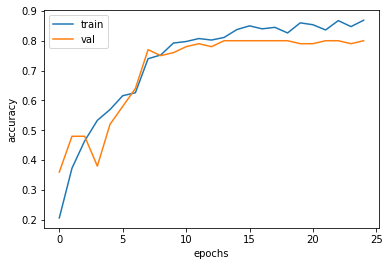

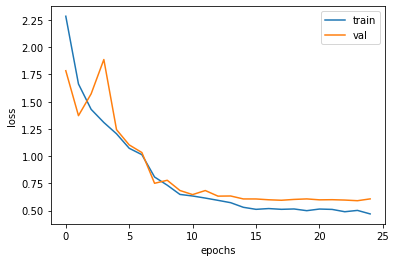

In [209]:
def plot_performance(metric, values):
  plt.plot(values['train'])
  plt.plot(values['val'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend(values.keys())
  plt.show()

plot_performance('accuracy', accuracies)
plot_performance('loss', losses)